# Cats and Dogs CNN

**Description:** Classify cats and dogs with a simple Convolutional Network<br>
                 
**Dataset:** Kaggle Dogs vs Cats dataset originally from Microsoft <br>
             Transformed Multiclass classifier to binary classifier using Softmax (2 classes) 

<a target="_blank" href="https://colab.research.google.com/github/castorgit/DL-course/blob/main/08_CNN_Cats_and_Dogs-Transfer_Learning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%matplotlib inline
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import Input
from tensorflow.keras.layers import ReLU, Dense, Softmax, Rescaling, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

import numpy as np

import sys
sys.stderr = open('err.txt', 'w')

AUGMENTATION = True

/home/jaumemanero/RL/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
I0000 00:00:1765810178.958003   16601 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:52:00.0, compute capability: 8.6
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
I0000 00:00:1765810189.003243   16745 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes befor

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


#### **Directories**
Reads the Cats and Dogs dataset and loads in. Creating a PetImages folder with two subfolders Cat and Dog <bbr>
Don't repeat this step as with the files/folders created it may have some issues

In [2]:
# Loading the dataset from microsoft cloud - do it only once
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  40.9M      0  0:00:19  0:00:19 --:--:-- 46.5M
/bin/bash: line 1: unzip: command not found


#### **Cleaning data**
Just for security we delete some photos that may have the header corrupted.

In [3]:
num_skipped = 0
num_images = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        else:
            num_images += 1

print(f"Deleted {num_skipped} images.")
print(f"There are {num_images} clean images.")

Deleted 0 images.
There are 23412 clean images.


#### **Preparing the data**

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


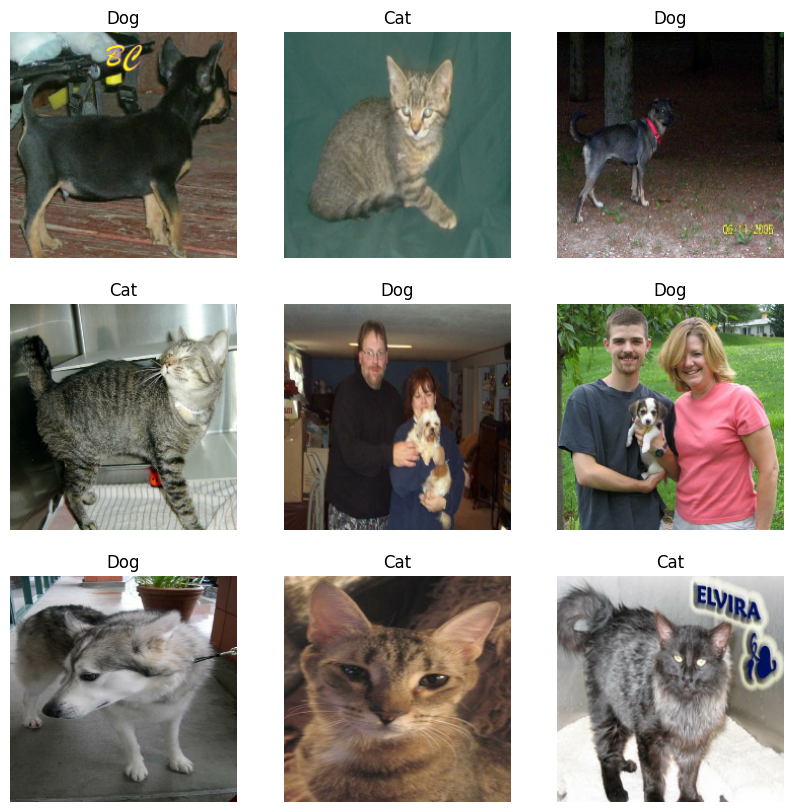

In [4]:
batch_size = 32
img_height = 224
img_width  = 224
train_dir = './PetImages/'
class_names = ['Cat', 'Dog']

train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'categorical',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'categorical',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check images

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
        
        
# Optional: Normalize pixel values (0-255 to 0-1)
normalization_layer = Rescaling(1./255)

train_dataset        = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset   = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

In [5]:
# Data Augmentation

In [6]:
def custom_augmentation(image, label):
    # Example augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return image, label

def custom_augmentation(image, label):
    # 1. Random horizontal and vertical flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # 2. Random rotation (angles in radians)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

    # 3. Random cropping or resizing
    crop_scale = tf.random.uniform([], 0.6, 0.8)  # Random scale for cropping

    # 4. Random brightness, contrast, and saturation adjustments
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)

    # 5. Random hue adjustment
    image = tf.image.random_hue(image, max_delta=0.04)

    return image, label


def custom_augmentation(image, label):
    # Example augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [7]:
augmented_train_dataset = train_dataset.map(custom_augmentation)
augmented_val_dataset = validation_dataset.map(custom_augmentation)

#### **Network Architecture Definition**

In [8]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(    
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)

base_model.trainable = False

inputs = Input(shape=(img_height, img_width, 3))
    
x = base_model(inputs)

# New layers
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
    
#Output layer
output = Dense(2, activation='softmax')(x)
    
model = Model(inputs=[inputs], outputs=output)

model.summary()
model.compile(loss='categorical_crossentropy',
             optimizer = Adam(learning_rate=0.001), metrics=['acc'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,226 (76.89 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [9]:
# training the network

In [10]:


#model = Sequential()
#model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
#model.add(Dense(1, activation='sigmoid'))
# ResNet-50 model is already trained, should not be trained
#model.layers[0].trainable = True

#model_pretrained = model
#model_pretrained.compile(loss='binary_crossentropy',
#             optimizer = Adam(learning_rate=0.001), metrics=['acc'])

In [11]:
AUGMENTATION=False
if AUGMENTATION:
    print ("Augmentation")
    history = model.fit(
      augmented_train_dataset,
      steps_per_epoch=50,
      epochs=30,
      validation_data=augmented_val_dataset)

else:
    print ("No Augmentation")
    history = model.fit(
      train_dataset,
      steps_per_epoch=50,
      epochs=30,
      validation_data=validation_dataset)


No Augmentation
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - acc: 0.7169 - loss: 0.5504 - val_acc: 0.8266 - val_loss: 0.4250
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - acc: 0.8144 - loss: 0.4023 - val_acc: 0.8289 - val_loss: 0.3831
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - acc: 0.8456 - loss: 0.3467 - val_acc: 0.8575 - val_loss: 0.3294
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - acc: 0.8419 - loss: 0.3353 - val_acc: 0.8486 - val_loss: 0.3387
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - acc: 0.8756 - loss: 0.2844 - val_acc: 0.8834 - val_loss: 0.2736
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - acc: 0.8831 - loss: 0.2748 - val_acc: 0.8883 - val_loss: 0.2652
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - acc: 0.8781 - loss: 0.2791 - val_acc: 0.8637 - val_loss: 0.3003
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - acc: 0.8806 - loss: 0.2703 - val_acc: 0.8612 - val_loss: 0.3033
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━

#### **Evaluate the Results**

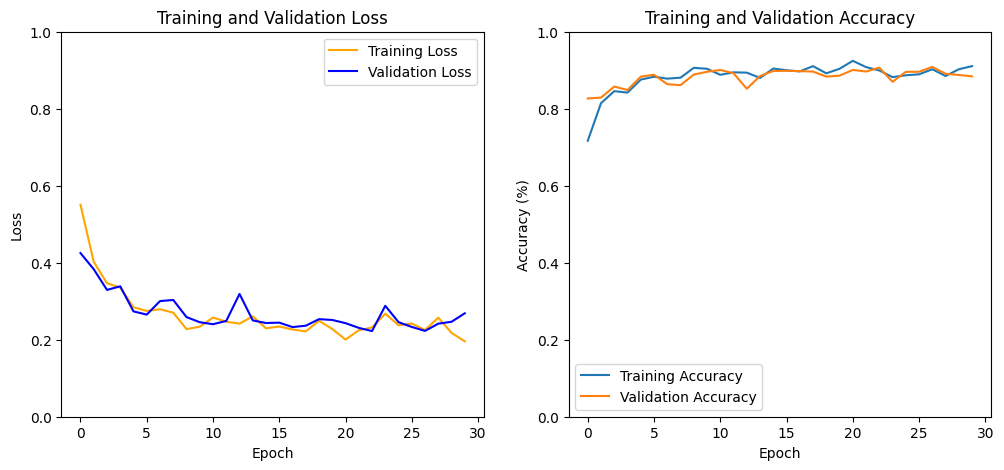

In [12]:
# Plot training loss, accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()


#### **Generate Confusion Matrix**

In [18]:
# Generate predictions for the validation dataset
y_true = []
y_pred = []

for images, labels in validation_dataset:
    y_true.extend(labels.numpy())  # True labels
    preds = model.predict(images, verbose=0)  # Model predictions
    y_pred.extend((preds > 0.5).astype(int))

y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)


In [19]:
y_true

array([0, 1, 1, ..., 0, 1, 0], shape=(4682,))

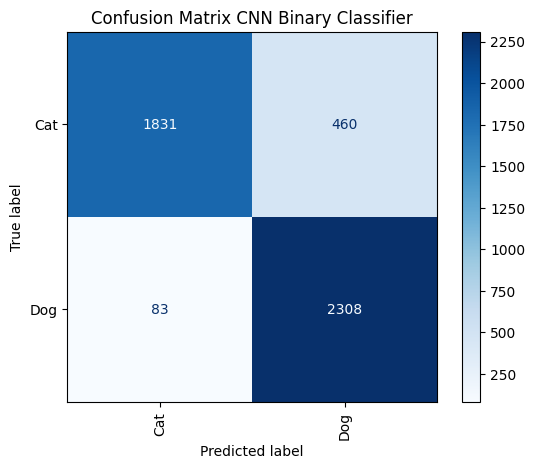

In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix CNN Binary Classifier")
plt.show()

In [22]:
# Final accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

print('final accuracy test:', acc[-1])
print('final accuracy validation', val_acc[-1])

final accuracy test: 0.9106249809265137
final accuracy validation 0.884023904800415


In [23]:
import session_info
session_info.show(html=False)

-----
keras               3.12.0
matplotlib          3.10.7
numpy               2.2.6
session_info        v1.0.1
sklearn             1.7.2
tensorflow          2.20.0
-----
IPython             8.37.0
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.4
-----
Python 3.10.12 (main, Nov  4 2025, 08:48:33) [GCC 11.4.0]
Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.35
-----
Session information updated at 2025-12-15 16:01
